$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cD {\mathcal{D}}$
$\def \bc {\mathbf{c}}$
$\def \bv {\mathbf{v}}$
$\def \bG {\mathbf{G}}$

# Greedy algorithms with a 2d manifold - L-shaped domain division

Here we consider the solutions of the PDE $u_h(a(y))$ where $y\in\mathbb{R}^2$, $a(y) = y_1 \chi_{D_1}(x) + y_2 \chi_{D_2}(x)$, and $D_1 = [0,1/2) \times [0,1] \cup [1/2,1] \times [0,1/2)$ and $D_2 = [1/2, 1] \times [1/2,1]$, and $\chi_{D_1}$, $\chi_{D_2}$ are the indicator functions on $D_1$, $D_2$.

We're given our measurement space $W_m = \mathrm{span}\{w_1,\ldots,w_m\}$. We have a series of measurements $\langle w_i, u\rangle_V$, and we write $w := P_{W_m} u$, the projection of $u$ in $W_m$. We try random, even, and even sinusoidal measurements.

__Remarks:__
 - __Note that $\dot{\cdot}{\cdot} = \dot{\cdot}{\cdot}_{V_h}$ here.__
 - We can __assume that the $\omega_i$ are orthonormal__ as it is a fixed basis.
 - We store $\dot{\omega_i}{v}$ for each $v\in \cD$, so can we di all projections and inner-products in $\mathbb{R}^m$? And furthermore without the need of a Gram matrix $\dot{\phi_i}{\phi_j}$ to do the projection or orthonormalisation of $\phi_i$?
 - Finally, remember that _we can not know anything about $u$ other than $w :=P_{W_m} u$_, and we abuse notation slightly and also write $w=\dot{\omega_i}{u}$ for the vector in $\mathbb{R}^m$.

We have a dictionary $\cD$ of solutions $v(y)$, which we get from generating points in $y\in\mathbb{R}^{2}$ and then $v(y) = \frac{u_h(a(y))}{\| u_h(a(y)) \|_{V_h}}$ (i.e. we normalise all elements). 

__Algorithms 1-3, the "pure greedy", "measurement based OMP" and "measurement based PP" are used here.__

In [2]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

def make_2d_param_soln(points, fem_div, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = []
    fields = []

    for p in points:
        field = pat.PWConstantSqDyadicL2(a_bar + c * np.array([[p[0], p[0]],[p[0], p[1]]]))
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = field, f = 1)
        fem_solver.solve()
        solns.append(fem_solver.u)
        
    return solns, fields

### Generate the solution $u$ that we want to approximate

[0.8 0.1]


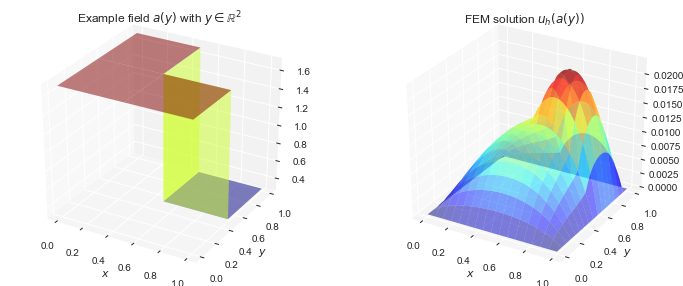

In [3]:
fem_div = 7

a_bar = 0.1
c = 2.0

np.random.seed(2)

y = np.array([[0.8, 0.1]])
print(y[0])
u, a = make_2d_param_soln(y, fem_div, a_bar=a_bar, c=c)
u = u[0]
a = a[0]

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
a.plot(ax, title='Example field $a(y)$ with $y\in\mathbb{R}^2$')
ax = fig.add_subplot(1, 2, 2, projection='3d')
u.plot(ax, title='FEM solution $u_h(a(y))$')
plt.show()

### Generate the basis $W_m$ of randomly placed local averages

m = 16


[]

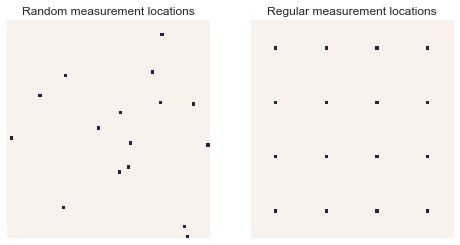

In [4]:
# local_width is the width of the measurement squares in terms of FEM mesh squares
width_div = 1
local_width = 2**width_div
spacing_div = 5

Wm_reg, Wloc_reg = pat.make_local_avg_grid_basis(width_div, spacing_div, fem_div, return_map=True)
Wm_reg = Wm_reg.orthonormalise()

m = Wm_reg.n
print('m =', m)

# We make the ambient spaces for Wm and Vn
np.random.seed(2)

Wm_rand, Wloc_rand = pat.make_pw_local_avg_random_basis(m=m, div=fem_div, width=local_width, return_map=True)
Wm_rand = Wm_rand.orthonormalise()

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(Wloc_rand.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Random measurement locations')
ax = fig.add_subplot(1, 2, 2)
sns.heatmap(Wloc_reg.values, xticklabels=False, yticklabels=False, cbar=False, ax=ax)
ax.set_title('Regular measurement locations')
plt.plot()

### Generate the dictionary of snapshots

In [6]:
dict_N = 50
dict_grid = np.linspace(0.0, 1.0, dict_N, endpoint=False)
y1s, y2s = np.meshgrid(dict_grid, dict_grid)

y1s = y1s.flatten()
y2s = y2s.flatten()

dict_ys = np.stack([y1s, y2s]).T

dictionary, dictionary_fields = make_2d_param_soln(dict_ys, fem_div, a_bar=a_bar, c=c)

In [7]:
greedy_algs = [pat.GreedyApprox(dictionary, Vn=pat.PWBasis(), verbose=True),
pat.MeasBasedOMP(dictionary, u, Wm_reg, Vn=pat.PWBasis(), verbose=True),
pat.MeasBasedPP(dictionary, u, Wm_reg, Vn=pat.PWBasis(), verbose=True),
pat.MeasBasedOMP(dictionary, u, Wm_rand, Vn=pat.PWBasis(), verbose=True),
pat.MeasBasedPP(dictionary, u, Wm_rand, Vn=pat.PWBasis(), verbose=True)]

greedy_algs_labels = ['Plain greedy', 
                      'Reg grid meas based OMP', 'Reg grid meas based PP', 
                      'Rand meas based OMP', 'Rand meas based PP',]

for g, l in zip(greedy_algs, greedy_algs_labels):
    print('Constructing ' + l)
    g.construct_to_n(m)

Constructing Plain greedy
i 	 Selection 	 Sel. criteria
1 : 	 0 	 0.46862352375087635
2 : 	 2450 		 0.19887054235746227
3 : 	 49 		 0.10160073350415336
4 : 	 300 		 0.014046526341075432
5 : 	 5 		 0.0011761470756462868
6 : 	 900 		 7.544347078230083e-05
7 : 	 14 		 1.4169347978873933e-06
8 : 	 100 		 1.726195128346546e-08


/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 6.404397080377639e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Vn spans all dictionary points at n=8, stopping greedy
Done!
Constructing Reg grid meas based OMP
i 	 Selection 	 Sel. criteria
1 : 	 123 	 0.03802754083961919
Vn spans all dictionary points at n=1, stopping greedy
Done!
Constructing Reg grid meas based PP
i 	 Selection 	 Sel. criteria
1 : 	 123 	 0.03802754083961919
Vn spans all dictionary points at n=1, stopping greedy
Done!
Constructing Rand meas based OMP
i 	 Selection 	 Sel. criteria
1 : 	 123 	 0.033412926965297365
Vn spans all dictionary points at n=1, stopping greedy
Done!
Constructing Rand meas based PP
i 	 Selection 	 Sel. criteria
1 : 	 123 	 0.033412926965297365
Vn spans all dictionary points at n=1, stopping greedy
Done!


In [9]:
for i, greedy in enumerate(greedy_algs):
    ps = dict_ys[np.array(greedy.dict_sel, dtype=np.int32), :]
    print(greedy_algs_labels[i])
    print(ps)

Plain greedy
[[0.   0.  ]
 [0.   0.98]
 [0.98 0.  ]
 [0.   0.12]
 [0.1  0.  ]
 [0.   0.36]
 [0.28 0.  ]
 [0.   0.04]]
Reg grid meas based OMP
[[0.46 0.04]]
Reg grid meas based PP
[[0.46 0.04]]
Rand meas based OMP
[[0.46 0.04]]
Rand meas based PP
[[0.46 0.04]]


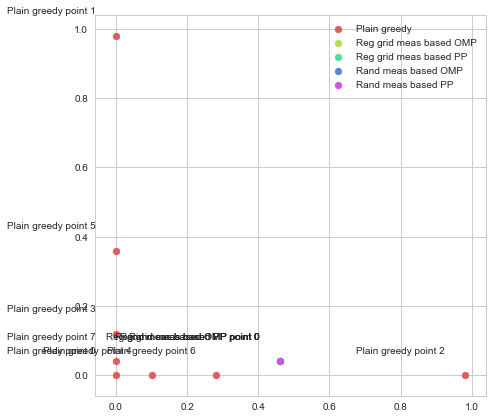

In [12]:
sns.set_palette('hls', len(greedy_algs))
sns.set_style('whitegrid')

fig = plt.figure(figsize=(7,7))

for i, greedy in enumerate(greedy_algs):
    labels = ['{0} point {1}'.format(greedy_algs_labels[i], j) for j in range(greedy.n)] 
    
    ps = dict_ys[np.array(greedy.dict_sel, dtype=np.int32), :]
    
    plt.scatter(ps[:, 0], ps[:, 1], marker='o', label=greedy_algs_labels[i])

    for label, x, y in zip(labels, ps[:, 0], ps[:, 1]):
        plt.annotate(label, xy=(x, y), xytext=(-20, 20), textcoords='offset points', ha='right', va='bottom')

plt.legend()
plt.show()

### What is the width of the "cone" of $V_n$?

We can calculate this using the eigenvalues of the grammian. Also, what what are the associated eigenvectors? Whoa. What does this all mean?

Evidently what I mean is for $v_1$ and $v_2$ that are _convex_ combinations (ermmmm...?)

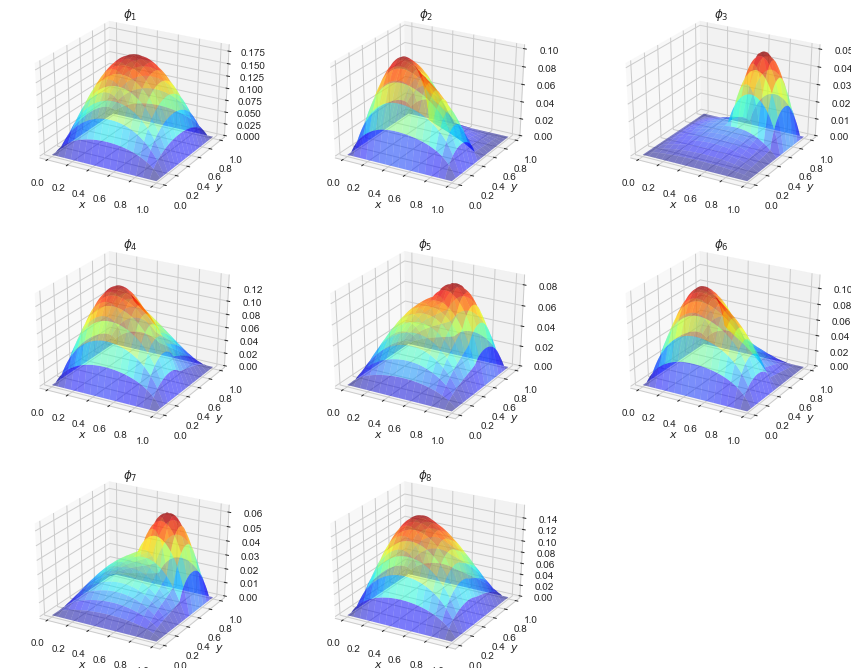

In [16]:
fig = plt.figure(figsize=(15,12))
for i, v in enumerate(g.Vn.vecs):
    
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    v.plot(ax, title=r'$\phi_{{{0}}}$'.format(i+1))

plt.show()

[  6.89433342e-01   6.36068385e-02   1.65928972e-02   1.94256145e-04
   1.12945918e-06   4.44771731e-09   1.47377328e-12   7.47118873e-17]
[-0.55169147 -0.30391885 -0.05953418 -0.41930826 -0.22757269 -0.34792941
 -0.12325071 -0.48566571]
[ 0.3612508  -0.55227271  0.30453794 -0.17247321  0.38514862 -0.41281734
  0.34294615  0.07505113]
[ 0.29528357 -0.4112719  -0.61051672  0.09201367 -0.21253075 -0.20120066
 -0.44859952  0.27490599]
[-0.33655007 -0.45726597  0.42802917  0.50038144 -0.39118644  0.12278993
  0.01663293  0.27508268]
[ 0.25410845  0.36336245  0.41345487 -0.28956074 -0.51007468 -0.42186837
 -0.18995309  0.27271781]
[-0.43500732  0.27015559 -0.28557683  0.23666233  0.16629972 -0.55928574
  0.31888603  0.39758894]
[-0.02553645 -0.1233305  -0.26139951 -0.47588846 -0.36547811  0.34426234
  0.57415423  0.32801534]
[-0.33199618 -0.06453456  0.16414609 -0.41141363  0.42458102  0.20899252
 -0.44525887  0.51692005]


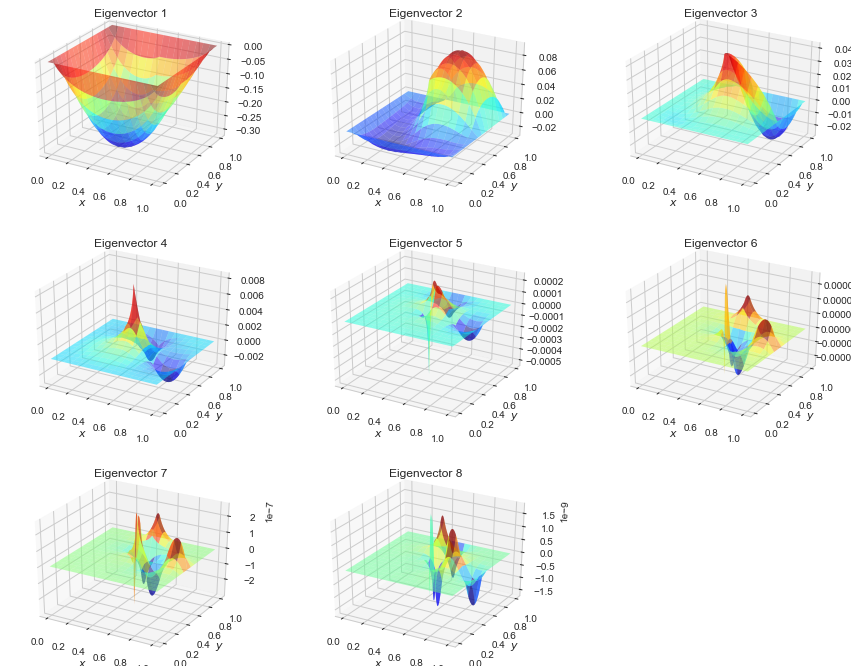

In [17]:
lam, V = np.linalg.eigh(g.Vn.G)
print(lam[::-1])

fig = plt.figure(figsize=(15,12))
for i, v in enumerate(V.T[::-1]):
    
    vec = g.Vn.reconstruct(v)
    print(v)
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    vec.plot(ax, title='Eigenvector {0}'.format(i+1))

plt.show()

### Do all convex combinations of $V_n$ have a corresponding $y$?